# Visualize GradCam
this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)


In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [30]:
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable

def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im


def apply_colormap_on_image(org_im, activation, colormap_name):
    color_map = cm.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)

    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))
    shapes = (org_im.detach().numpy().shape[1], org_im.detach().numpy().shape[0])
    heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)
    org_im = Image.fromarray(org_im.detach().numpy(), 'RGBA')
    heatmap_on_image =  Image.blend(org_im, heatmap_on_image, 0.5)
    return no_trans_heatmap, heatmap_on_image

def save_class_activation_images(org_img, activation_map):
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    activation_map = save_image(activation_map )
    return heatmap, heatmap_on_image, activation_map

In [31]:


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        target = conv_output.data.numpy()[0]
        weights = np.mean(guided_gradients, axis=(1, 2))
        cam = np.ones(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam




In [32]:
pret_mod = models.alexnet(pretrained=True)

grad_cam = GradCam(pret_mod, target_layer=11)
im, pred_cls = process_img(img, pret_mod)
cam = grad_cam.generate_cam(im, pred_cls)

heatmap, heatmap_on_image, activation_map = save_class_activation_images(im, cam)

<ipython-input-31-bbdecda0b81c>:65: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image.shape[3]), Image.ANTIALIAS))/255
<ipython-input-30-9964181398ff>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap(colormap_name)
<ipython-input-30-9964181398ff>:49: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)


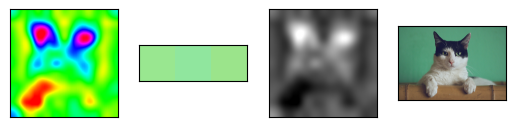

In [43]:
fig, axis = plt.subplots(1, 4)
for ax in axis:
    ax.set_xticks([])
    ax.set_yticks([])
axis[0].imshow(heatmap)
axis[1].imshow(heatmap_on_image)
axis[2].imshow(activation_map)
axis[3].imshow(img)